### Installation

In [ ]:
!pip install --user -U nltk
!pip install transformers
!pip install farasapy
!git clone https://github.com/aub-mind/arabert
!pip install tashaphyne
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'arabert' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import libraries

In [ ]:
import re
import random
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from setuptools import setup
import re
import nltk
from arabert.preprocess import ArabertPreprocessor
from nltk.corpus import stopwords
from textblob import TextBlob
from tashaphyne.stemming import ArabicLightStemmer
from nltk.corpus import stopwords
import string
import sys
import argparse
import json
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.utils import to_categorical
import os
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/rashad.csv',on_bad_lines='skip',delimiter = "\t")
df= df.drop(labels=range(0, 3), axis=0)
df.columns=['arabic_question','arabic_Answer']

In [ ]:
df.head(100)

,arabic_question,arabic_Answer
3,صباحو,صباح النور تفضل
4,صباح الخير,صباح النور تفضل
5,السلام عليكم,وعليكم السلام تفضل
6,مسائو,مسالنور تفضل
7,مسا الخير,مسالنور تفضل
...,...,...
98,هل الجاكية رقم 1 قطن,نعم الجاكية رقم 1 قطنية
99,هل يوجد مقاس مختلف من الجاكيت رقم 1,لدي مقاسات ولكن من جواكي اخرى
100,يوجد مقاس مختلف من الجاكيت رقم 1,لدي مقاسات ولكن من جواكي اخرى
101,أيوجد مقاس مختلف من الجاكيت رقم 1,لدي مقاسات ولكن من جواكي اخرى


Info about the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13035 entries, 3 to 13037
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   arabic_question  13035 non-null  object
 1   arabic_Answer    13035 non-null  object
dtypes: object(2)
memory usage: 305.5+ KB


In [ ]:
print(df.duplicated().sum()) #check duplicates
print(df.isnull().sum()) #check null values

596
arabic_question    0
arabic_Answer      0
dtype: int64


In [ ]:
print(df.drop_duplicates(inplace=True,keep='last'))

None


In [ ]:
df1=df.copy() #make a copy from dataset

In [ ]:
df1['arabic_Answer'] = df['arabic_Answer'].str.split('$').str.get(0) # split sentences from $ until the end

In [ ]:
df1['arabic_Answer']

3                 صباح النور تفضل
4                 صباح النور تفضل
5              وعليكم السلام تفضل
6                    مسالنور تفضل
7                    مسالنور تفضل
                   ...           
13033    تقصد الرجالي أم النسائي 
13034    تقصد الرجالي أم النسائي 
13035    تقصد الرجالي أم النسائي 
13036    تقصد الرجالي أم النسائي 
13037    تقصد الرجالي أم النسائي 
Name: arabic_Answer, Length: 12439, dtype: object

### Preprocessing part

In [ ]:
import pyarabic.araby as araby
def normalizeArabic(text):
  text = text.strip()
  text = re.sub("[إأٱآا]", "ا", text)
  text = re.sub("ى", "ي", text)
  text = re.sub("ؤ", "ء", text)
  text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", text)
  text = re.sub("او", "", text)
  noise = re.compile(""" ّ    | # Tashdid
                        َ    | # Fatha
                        ً    | # Tanwin Fath
                        ُ    | # Damma
                        ٌ    | # Tanwin Damm
                        ِ    | # Kasra
                        ٍ    | # Tanwin Kasr
                        ْ    | # Sukun
                        ـ     # Tatwil/Kashida
                    """, re.VERBOSE)
  text = re.sub(noise, '', text)
  text= re.sub('[\\s]+'," ",text) # Remove all spaces
  return araby.strip_tashkeel(text)

In [ ]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
df1['arabic_Answer']=  df1.arabic_Answer.apply(lambda elem:normalizeArabic(elem))

In [ ]:
df1.arabic_question=  df1.arabic_question.apply(lambda elem:normalizeArabic(elem))

In [ ]:
df1['arabic_question'] =  df1['arabic_question'].apply(lambda elem: remove_punctuations(elem))
df1['arabic_Answer'] =  df1['arabic_Answer'].apply(lambda elem: remove_punctuations(elem))


#model

In [ ]:
questions =  df1.arabic_question	.values.tolist()
print(len(questions))
answers = df1.arabic_Answer.values.tolist()
print(len(answers))

12439
12439


In [ ]:
# add a start word at the beginning of the sentence and an end word at the end.
answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str :
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )
answers = list()
for i in range( len( answers_with_tags ) ) :
    answers.append('<START>'+answers_with_tags[i]+ ' <END>' )

In [ ]:
import pickle
with open('answers_arabic.pkl', 'wb') as file:
    pickle.dump(answers, file)
with open('questions_arabic.pkl', 'wb') as file:
    pickle.dump(questions, file)

In [ ]:
tokenizer =Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))
##Encoder
tokenizer = Tokenizer()
tokenizer.fit_on_texts( questions ) 
tokenized_questions = tokenizer.texts_to_sequences( questions ) 

max_input_length= max(len(seq) for seq in tokenized_questions)
print('max_input_length: ', max_input_length)

padded_questions =pad_sequences( tokenized_questions , maxlen=max_input_length , padding='post' )
encoder_input_data = np.array( padded_questions )
print( 'Encoder input data shape -> {}'.format( encoder_input_data.shape ))

input_word_dict = tokenizer.word_index
num_input_tokens = len( input_word_dict )+1
print( 'Number of input tokens = {}'.format( num_input_tokens))
##Decoder
tokenizer = Tokenizer()
tokenizer.fit_on_texts( answers ) 
tokenized_output_lines = tokenizer.texts_to_sequences( answers ) 
max_output_length= max(len(seq) for seq in tokenized_output_lines)
print('max_output_length: ', max_output_length)

padded_output_lines =pad_sequences( tokenized_output_lines , maxlen=max_output_length, padding='post' )
decoder_input_data = np.array( padded_output_lines )
print( 'Decoder input data shape -> {}'.format( decoder_input_data.shape ))

output_word_dict = tokenizer.word_index
num_output_tokens = len( output_word_dict )+1
print( 'Number of Output tokens = {}'.format( num_output_tokens))
decoder_target_data = list()
for token_seq in tokenized_output_lines:
    decoder_target_data.append( token_seq[ 1 : ] ) 
    
padded_output_lines =pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
onehot_output_lines =to_categorical( padded_output_lines , VOCAB_SIZE )
decoder_target_data = np.array(onehot_output_lines )
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape ))

VOCAB SIZE : 550
max_input_length:  10
Encoder input data shape -> (12439, 10)
Number of input tokens = 439
max_output_length:  18
Decoder input data shape -> (12439, 18)
Number of Output tokens = 327
Decoder target data shape -> (12439, 18, 550)


In [ ]:
#Encoder
encoder_inputs = tf.keras.layers.Input(shape=( None , )) # none or max length for the question
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 100 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 64 , return_state=True ,dropout=0.3)( encoder_embedding )
encoder_states = [ state_h , state_c ]
#decoder
decoder_inputs = tf.keras.layers.Input(shape=( None ,  )) #none or max length for the answers
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 100 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 64 , return_state=True , return_sequences=True,dropout=0.3 )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy',metrics=['acc'])

model.summary()
h=model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=32, epochs=23) 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    55000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    55000       ['input_2[0][0]']                
                                                                                              

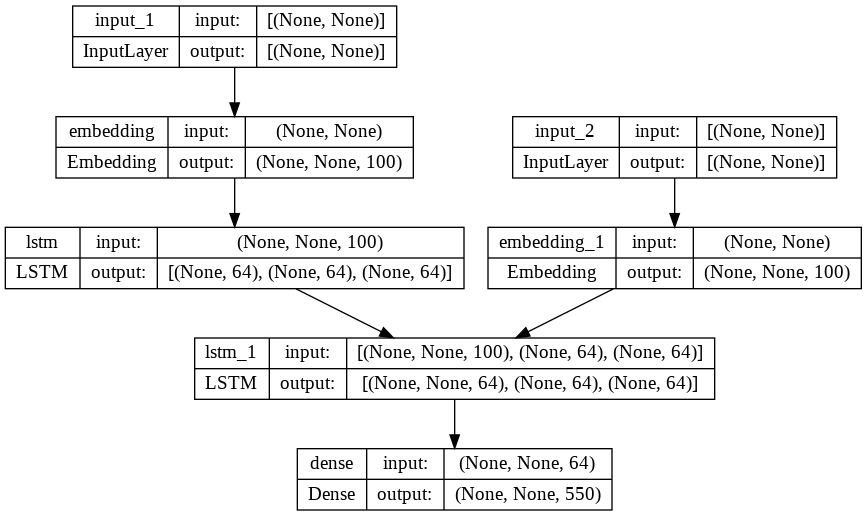

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [ ]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 64 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 64 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model
def str_to_tokens( sentence : str ):
    words =normalizeArabic(sentence).split()
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')

In [ ]:
enc_model , dec_model = make_inference_models()
enc_model=enc_model.save('Arabic_encoder_model.h5')
dec_model=dec_model.save('Arabic_decoder_model.h5')

In [ ]:
def decode_response(text):
        states_values = enc_model.predict(text )
        empty_target_seq = np.zeros( ( 1 , 1 ) )
        empty_target_seq[0, 0] = tokenizer.word_index['start']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition :
            dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
            sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
            sampled_word = None
            for word , index in tokenizer.word_index.items() :
                if sampled_word_index == index :
                    decoded_translation += ' {}'.format( word )
                    sampled_word = word
#             else:
#                 decoded_translation = "I am sorry! I don't understand you"
        
            if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
               stop_condition = True
            
            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            states_values = [ h , c ] 
        return "Bot:" +decoded_translation.replace(' end', '')

In [ ]:
def generate_response(text):
    input_matrix = str_to_tokens(text)
    chatbot_response = decode_response(input_matrix)
  #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response

In [ ]:
generate_response("مقاس 38 من البنطال الجينز الأسود")

1/1 [==============================] - 0s 14ms/step


'Bot: يوجد مقاساتات من موديل اخر'